# Progression of DAPI stain properties through time

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %load common_.py
from common import *

In [3]:
import umap
import dask.dataframe as dd
from ehv import core, load as e_load
from joblib import dump, load
from pathlib import Path
from matplotlib import cm
import matplotlib
import statsmodels.api as sm

In [4]:
df = e_load.load_raw_ideas_dir(
    Path("/data/weizmann/EhV/high_time_res"), 
    Path("/data/weizmann/EhV/weizmann-ehv-metadata/representations/ideas_features/"), 
    "ALL", 
    Path("/data/weizmann/EhV/weizmann-ehv-metadata/cell_populations/manual_gating/"))
df = e_load.remove_unwanted_features(df)
df = e_load.tag_columns(df)

In [5]:
df = df[df["meta_label_COI"] & (df["meta_group"] == "Low")]
df.shape

(339045, 113)

In [8]:
import re
reg = r"^meta_label_(.+)$"
label_vec = numpy.full((df.shape[0]), fill_value="unknown", dtype=object)
for col in df.filter(regex="(?i)meta_label_.*psba.*"):
    label_vec[df[col].values] = re.match(reg, col).groups(1)
    
df["meta_label"] = label_vec

## Does DAPI circularity change through time?

Circularity can be approximated in the IDEAS feature set by the aspect ratio (1 = circular, not 1 is oval). 

In [6]:
df.filter(regex="(?i)aspect.*7").head()

,feat_Aspect Ratio_M07,feat_Aspect Ratio Intensity_M07_Ch7
2,0.966461,0.954871
3,0.843450,0.692018
4,0.977376,0.920228
6,0.908348,0.848956
7,0.939528,0.835031


In [ ]:
df["feat_Intensity_MC_Ch04"]

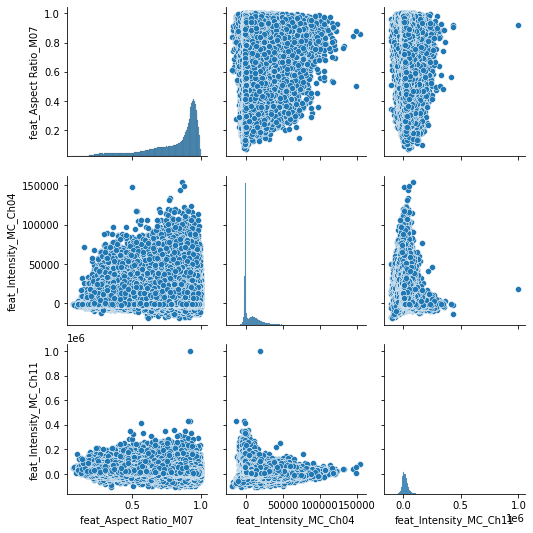

In [10]:
seaborn.pairplot(df[["feat_Aspect Ratio_M07", "feat_Intensity_MC_Ch04", "feat_Intensity_MC_Ch11"]])

## Regression over all cells

<AxesSubplot:xlabel='meta_timepoint', ylabel='feat_Aspect Ratio_M07'>

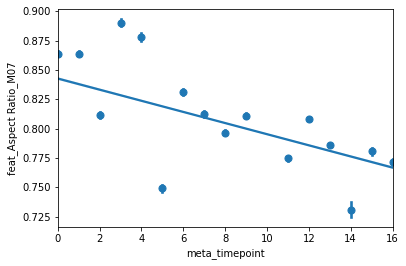

In [37]:
seaborn.regplot(data=df, y="feat_Aspect Ratio_M07", x="meta_timepoint", x_estimator=numpy.mean)

In [40]:
results = sm.OLS(df['feat_Aspect Ratio_M07'], df['meta_timepoint']).fit()

In [41]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                  
==========================================================================================
Dep. Variable:     feat_Aspect Ratio_M07   R-squared (uncentered):                   0.665
Model:                               OLS   Adj. R-squared (uncentered):              0.665
Method:                    Least Squares   F-statistic:                          6.725e+05
Date:                   Thu, 25 Feb 2021   Prob (F-statistic):                        0.00
Time:                           15:58:09   Log-Likelihood:                     -2.3253e+05
No. Observations:                 339045   AIC:                                  4.651e+05
Df Residuals:                     339044   BIC:                                  4.651e+05
Df Model:                              1                                                  
Covariance Type:               nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
meta_timepoint     0.0795    9.7e-05    820.056      0.000       0.079       0.080
==============================================================================
Omnibus:                    38255.150   Durbin-Watson:                   0.287
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10873.094
Skew:                          -0.095   Prob(JB):                         0.00
Kurtosis:                       2.144   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Regression per population

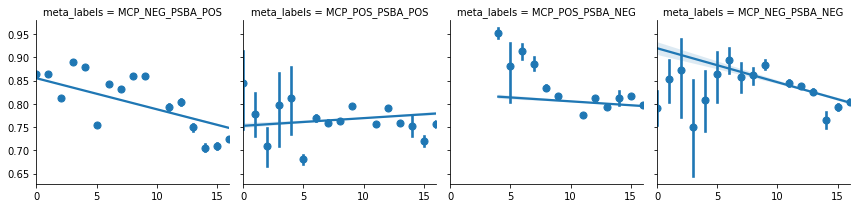

In [49]:
grid = seaborn.FacetGrid(data=df[df["meta_labels"] != "unknown"], col="meta_label", col_order=["MCP_NEG_PSBA_POS", "MCP_POS_PSBA_POS", "MCP_POS_PSBA_NEG", "MCP_NEG_PSBA_NEG"])
grid.map_dataframe(seaborn.regplot, y="feat_Aspect Ratio_M07", x="meta_timepoint", x_estimator=numpy.mean)

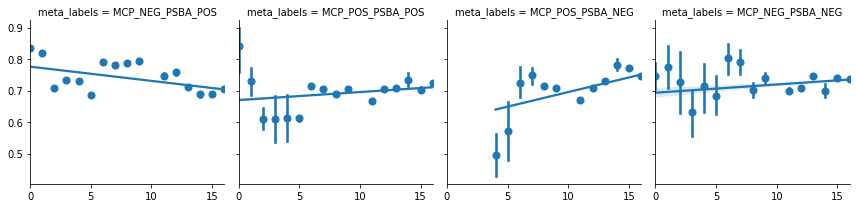

In [50]:
grid = seaborn.FacetGrid(data=df[df["meta_labels"] != "unknown"], col="meta_label", col_order=["MCP_NEG_PSBA_POS", "MCP_POS_PSBA_POS", "MCP_POS_PSBA_NEG", "MCP_NEG_PSBA_NEG"])
grid.map_dataframe(seaborn.regplot, y="feat_Aspect Ratio_M01", x="meta_timepoint", x_estimator=numpy.mean)

In [58]:
results = {}
for idx, gdf in df.groupby("meta_label"):
    print(idx)
    X = sm.add_constant(gdf["feat_Aspect Ratio_M07"])
    results[idx] = sm.OLS(gdf["meta_timepoint"].values.ravel(), X).fit()

MCP_NEG_PSBA_NEG
MCP_NEG_PSBA_POS
MCP_POS_PSBA_NEG
MCP_POS_PSBA_POS
unknown


In [60]:
results["MCP_POS_PSBA_NEG"].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     31.76
Date:                Fri, 26 Feb 2021   Prob (F-statistic):           1.75e-08
Time:                        11:49:08   Log-Likelihood:            -1.3555e+05
No. Observations:               62599   AIC:                         2.711e+05
Df Residuals:                   62597   BIC:                         2.711e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    12.1611      0.044    277.082      0.000      12.075      12.247
feat_Aspect Ratio_M07    -0.3026      0.054     -5.635      0.000      -0.408      -0.197
==============================================================================
Omnibus:                      435.993   Durbin-Watson:                   0.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              323.912
Skew:                           0.077   Prob(JB):                     4.61e-71
Kurtosis:                       2.683   Cond. No.                         10.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [67]:
from patsy.contrasts import ContrastMatrix

def _name_levels(prefix, levels):
    return ["[%s%s]" % (prefix, level) for level in levels]

class Simple(object):
    def _simple_contrast(self, levels):
        nlevels = len(levels)
        contr = -1./nlevels * numpy.ones((nlevels, nlevels-1))
        contr[1:][numpy.diag_indices(nlevels-1)] = (nlevels-1.)/nlevels
        return contr

    def code_with_intercept(self, levels):
        contrast = numpy.column_stack((numpy.ones(len(levels)),
                                    self._simple_contrast(levels)))
        return ContrastMatrix(contrast, _name_levels("Simp.", levels))

    def code_without_intercept(self, levels):
        contrast = self._simple_contrast(levels)
        return ContrastMatrix(contrast, _name_levels("Simp.", levels[:-1]))

In [71]:
levels = range(len(df["meta_timepoint"].unique()))
timepoint_contrast = Simple().code_without_intercept(levels)
timepoint_contrast.matrix.shape

(16, 15)

In [73]:
from patsy.contrasts import Diff
levels = range(len(df["meta_replicate"].unique()))
replicate_contrast = Diff().code_without_intercept(levels)
replicate_contrast.matrix

array([[-0.66666667, -0.33333333],
       [ 0.33333333, -0.33333333],
       [ 0.33333333,  0.66666667]])

In [74]:
from patsy.contrasts import Diff
levels = range(len(df["meta_label"].unique()))
label_contrast = Diff().code_without_intercept(levels)
label_contrast.matrix

array([[-0.8, -0.6, -0.4, -0.2],
       [ 0.2, -0.6, -0.4, -0.2],
       [ 0.2,  0.4, -0.4, -0.2],
       [ 0.2,  0.4,  0.6, -0.2],
       [ 0.2,  0.4,  0.6,  0.8]])

In [64]:
X = sm.add_constant(df[["meta_timepoint", "meta_replicate", "meta_label"]])
res = sm.OLS(df["feat_Aspect Ratio_M07"], X)

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).